In [2]:
!pip install -U pip setuptools wheel
!pip install -U "matplotlib>=3.8" "seaborn>=0.13" pandas numpy
!pip install -q xgboost

In [3]:
import matplotlib
print(matplotlib.__version__)  # should be >= 3.4

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
# import seaborn as sns


3.9.4



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/ziad/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/ziad/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/ziad/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/ziad/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/ziad/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/ziad/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/ziad/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/ziad/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  

AttributeError: _ARRAY_API not found

In [4]:


# ---------- 1. Load JSON Lines file ----------
file_path = "../data/customer_churn.json"
df = pd.read_json(file_path, lines=True)

# ---------- 2. Convert timestamps ----------
df['datetime'] = pd.to_datetime(df['ts'], unit='ms', errors='coerce')
df['registration_datetime'] = pd.to_datetime(df['registration'], unit='ms', errors='coerce')

# ---------- 3. Add derived columns ----------
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour

# Days since registration
df['days_since_registration'] = (df['datetime'] - df['registration_datetime']).dt.days

# ---------- 4. Session duration (in minutes) ----------
session_duration = df.groupby('sessionId')['datetime'].agg(lambda x: (x.max() - x.min()).total_seconds() / 60)
df = df.merge(session_duration.rename('session_duration_min'), on='sessionId', how='left')

# ---------- 5. Extract browser & OS ----------
# Browser
df['agent_simple'] = df['userAgent'].str.extract(r'(Firefox|Chrome|Safari|Edge|MSIE|Opera)')
# OS
df['os_simple'] = df['userAgent'].str.extract(r'(Windows|Macintosh|Linux|iPhone|Android)')

# ---------- 6. Handle missing values ----------
# Keep NaNs for now; we’ll decide case-by-case in plotting
df['userId'] = df['userId'].replace('', np.nan)

# ---------- 7. Quick sanity check ----------
print(df.shape)
df.head()

(543705, 26)


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,song,length,datetime,registration_datetime,date,hour,days_since_registration,session_duration_min,agent_simple,os_simple
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX",...,Grand Designs,597.55057,2018-10-01 00:00:11,2018-07-20 05:11:47,2018-10-01,0,72.0,44637.966667,Chrome,Macintosh
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX",...,Bulls,380.21179,2018-10-01 00:00:25,2018-09-27 17:33:58,2018-10-01,0,3.0,49953.833333,Chrome,Macintosh
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL",...,Because I Got High,202.37016,2018-10-01 00:01:58,2018-09-03 05:44:15,2018-10-01,0,27.0,18346.950000,Chrome,Macintosh
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL",...,NaN,NaN,2018-10-01 00:01:59,2018-09-03 05:44:15,2018-10-01,0,27.0,18346.950000,Chrome,Macintosh
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",...,Smile (Radio Edit),194.53342,2018-10-01 00:02:04,2018-09-02 23:30:18,2018-10-01,0,28.0,39693.983333,Firefox,Windows


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# work on a sorted copy (we won't mutate df until logic is verified)
df_chk = df.sort_values(['userId', 'datetime']).copy()

# churn pages per your definition
churn_pages = {"Submit Downgrade"}

# neighbors
prev_level = df_chk.groupby('userId')['level'].shift()
next_level = df_chk.groupby('userId')['level'].shift(-1)

# check-only churn flag (event-level)
is_churn_event = (
    df_chk['page'].isin(churn_pages) &
    (prev_level == 'paid') &
    (next_level == 'free')
)

print("Detected churn events (check-only):", int(is_churn_event.sum()))

# commit churn event to df (event-level)
df = df.sort_values(['userId','datetime']).copy()
df['prev_level'] = df.groupby('userId')['level'].shift()
df['next_level'] = df.groupby('userId')['level'].shift(-1)
df['is_churn'] = (
    df['page'].isin(churn_pages) &
    (df['prev_level'] == 'paid') &
    (df['next_level'] == 'free')
)

# first churn timestamp per user
user_churn_date = df.loc[df['is_churn']].groupby('userId')['datetime'].min()
df['is_churned_user'] = df['userId'].isin(user_churn_date.index)

print(f"Churned users: {len(user_churn_date)} / {df['userId'].nunique()}")

# ---------- 8. Define churn ----------
user_churn_date = df.loc[df['is_churn']].groupby('userId')['datetime'].min()
df['is_churned_user'] = df['userId'].isin(user_churn_date.index)

print(f"Churned users: {len(user_churn_date)} / {df['userId'].nunique()}")

Detected churn events (check-only): 117
Churned users: 97 / 448
Churned users: 97 / 448


# 1 Data Engineering

In [6]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier

# === CONFIG ===
HORIZON_DAYS = 10          # predict churn within next N days
RECENT_WINDOW = 7         # recent activity window (days)
LONG_WINDOW = 14  # compare 7d vs 30d behavior

PAGES = [
    "NextSong", "Thumbs Up", "Thumbs Down",
    "Add to Playlist", "Add Friend", "Help", "Error",
    "Downgrade", "Submit Downgrade", "Home", "Roll Advert"
]

def safe_div(a, b):
    return np.where(b==0, 0.0, a / b)

In [7]:
# Assumes df already loaded with 'datetime' (tz-naive) and churn detection columns set
df = df.copy()
df['date'] = df['datetime'].dt.floor('D')

# First churn timestamp per user
user_churn_ts = df.loc[df['is_churn']].groupby('userId')['datetime'].min()
user_first_date = df.groupby('userId')['date'].min()
user_last_date  = df.groupby('userId')['date'].max()

# Per-day total events
daily_events = df.groupby(['userId','date']).size().rename('events').to_frame()

# Per-day listening time (sum seconds)
daily_listen = df.groupby(['userId','date'])['length'].sum(min_count=1).rename('listen_sec').to_frame()

# Per-day counts per page
daily_pages = (
    df[df['page'].isin(PAGES)]
      .groupby(['userId','date','page'])
      .size()
      .unstack(fill_value=0)
)

# Merge daily features
daily = daily_events.join(daily_listen, how='outer').join(daily_pages, how='outer').fillna(0)

# Build a continuous daily index per user (fill missing dates)
frames = []
for uid, g in daily.groupby(level=0):
    start = user_first_date.loc[uid]
    end   = user_last_date.loc[uid]
    full_idx = pd.MultiIndex.from_product([[uid], pd.date_range(start, end, freq='D')], names=['userId','date'])
    frames.append(g.reindex(full_idx).fillna(0))
daily_full = pd.concat(frames).sort_index()

# Attach churn date to each row
daily_full = daily_full.reset_index()
daily_full['churn_ts'] = daily_full['userId'].map(user_churn_ts)
daily_full['churn_date'] = daily_full['churn_ts'].dt.floor('D')

# Build user-level maps
reg_map = df.groupby('userId')['registration_datetime'].min()
gender_map = (
    df.dropna(subset=['userId'])
      .drop_duplicates('userId')
      .set_index('userId')['gender']
      .map({'F': 0, 'M': 1})         # F=0, M=1, Na/other=-1
      .fillna(-1)
)

# Attach to daily_full
daily_full['registration_datetime'] = daily_full['userId'].map(reg_map)
daily_full['gender_code']           = daily_full['userId'].map(gender_map)

# Calendar features from the row’s date (safe, no future info)
daily_full['day_of_month'] = daily_full['date'].dt.day         # 1..31
daily_full['day_of_week']  = daily_full['date'].dt.dayofweek+1 # 1=Mon .. 7=Sun

# Days since join (relative to user’s registration date; floor to day)
daily_full['days_since_join'] = (
    daily_full['date'] - daily_full['registration_datetime'].dt.floor('D')
).dt.days

daily_full['dow_sin'] = np.sin(2*np.pi*(daily_full['day_of_week']/7.0))
daily_full['dow_cos'] = np.cos(2*np.pi*(daily_full['day_of_week']/7.0))
daily_full['dom_sin'] = np.sin(2*np.pi*(daily_full['day_of_month']/31.0))
daily_full['dom_cos'] = np.cos(2*np.pi*(daily_full['day_of_month']/31.0))



In [8]:
# assumes: RECENT_WINDOW, LONG_WINDOW, PAGES, safe_div already defined

def add_rolling_features(df_user):
    base_cols = ['days_since_join','gender_code','day_of_month','day_of_week',
                 'dow_sin','dow_cos','dom_sin','dom_cos','artist_entropy_day']

    # core event columns present in this user's frame
    cols_core = ['events','listen_sec'] + [c for c in df_user.columns if c in PAGES]

    # cumulative since join (no leakage)
    cum = df_user[cols_core].cumsum().add_prefix('cum_')

    # rolling windows (dynamic)
    winS = df_user[cols_core].rolling(RECENT_WINDOW, min_periods=1).sum().add_prefix(f'win{RECENT_WINDOW}_')
    winL = df_user[cols_core].rolling(LONG_WINDOW,   min_periods=1).sum().add_prefix(f'win{LONG_WINDOW}_')

    out = pd.concat([df_user, cum, winS, winL], axis=1)

    # lifetime ratios
    out['ratio_thumbs_up'] = safe_div(out.get('cum_Thumbs Up',0), out.get('cum_NextSong',0))
    out['ratio_playlist']  = safe_div(out.get('cum_Add to Playlist',0), out.get('cum_NextSong',0))
    out['ratio_friend']    = safe_div(out.get('cum_Add Friend',0), out.get('cum_NextSong',0))

    # recent ratios (dynamic names)
    out[f'ratio{RECENT_WINDOW}_thumbs_up'] = safe_div(out.get(f'win{RECENT_WINDOW}_Thumbs Up',0),
                                                      out.get(f'win{RECENT_WINDOW}_NextSong',0))
    out[f'ratio{LONG_WINDOW}_thumbs_up']   = safe_div(out.get(f'win{LONG_WINDOW}_Thumbs Up',0),
                                                      out.get(f'win{LONG_WINDOW}_NextSong',0))

    out[f'ratio{RECENT_WINDOW}_playlist']  = safe_div(out.get(f'win{RECENT_WINDOW}_Add to Playlist',0),
                                                      out.get(f'win{RECENT_WINDOW}_NextSong',0))
    out[f'ratio{LONG_WINDOW}_playlist']    = safe_div(out.get(f'win{LONG_WINDOW}_Add to Playlist',0),
                                                      out.get(f'win{LONG_WINDOW}_NextSong',0))

    out[f'ratio{RECENT_WINDOW}_friend']    = safe_div(out.get(f'win{RECENT_WINDOW}_Add Friend',0),
                                                      out.get(f'win{RECENT_WINDOW}_NextSong',0))
    out[f'ratio{LONG_WINDOW}_friend']      = safe_div(out.get(f'win{LONG_WINDOW}_Add Friend',0),
                                                      out.get(f'win{LONG_WINDOW}_NextSong',0))

    # change features: recent vs lifetime; recent vs long
    out['chg_thumbs_up'] = out[f'ratio{RECENT_WINDOW}_thumbs_up'] - out['ratio_thumbs_up']
    out['chg_playlist']  = out[f'ratio{RECENT_WINDOW}_playlist']  - out['ratio_playlist']
    out['chg_friend']    = out[f'ratio{RECENT_WINDOW}_friend']    - out['ratio_friend']

    out[f'delta{RECENT_WINDOW}_{LONG_WINDOW}_thumbs']   = out[f'ratio{RECENT_WINDOW}_thumbs_up'] - out[f'ratio{LONG_WINDOW}_thumbs_up']
    out[f'delta{RECENT_WINDOW}_{LONG_WINDOW}_playlist'] = out[f'ratio{RECENT_WINDOW}_playlist']  - out[f'ratio{LONG_WINDOW}_playlist']

    # error/help intensity (recent window)
    out[f'win{RECENT_WINDOW}_error_rate'] = safe_div(out.get(f'win{RECENT_WINDOW}_Error',0),
                                                     out.get(f'win{RECENT_WINDOW}_events',0))
    out[f'win{RECENT_WINDOW}_help_rate']  = safe_div(out.get(f'win{RECENT_WINDOW}_Help',0),
                                                     out.get(f'win{RECENT_WINDOW}_events',0))

    # downgrade without submit so far (lifetime)
    out['downgrade_wo_submit'] = ((out.get('cum_Downgrade',0) > 0) &
                                  (out.get('cum_Submit Downgrade',0) == 0)).astype(int)

    # cumulative nextsong proportion (engagement proxy)
    out['prop_nextsong'] = safe_div(out.get('cum_NextSong',0), out.get('cum_events',1))

    # ensure base cols exist
    for c in base_cols:
        if c not in out.columns:
            out[c] = np.nan

    
    return out

feat = daily_full.groupby('userId', group_keys=False).apply(add_rolling_features)





/var/folders/tm/v7g9kc693pv9880dllxx5b800000gn/T/ipykernel_70518/3504518389.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feat = daily_full.groupby('userId', group_keys=False).apply(add_rolling_features)


In [9]:
# Compute label: churn within next HORIZON_DAYS (strictly after 'date')
feat['label_churn_horizon'] = 0
mask_has_churn = feat['churn_date'].notna()
feat.loc[
    mask_has_churn &
    (feat['churn_date'] > feat['date']) &
    (feat['churn_date'] <= feat['date'] + pd.Timedelta(days=HORIZON_DAYS)),
    'label_churn_horizon'
] = 1

# Optional: drop rows AFTER churn date (no more predictions once churned)
feat = feat[
    (~mask_has_churn) | (feat['date'] <= feat['churn_date'])
].copy()

In [10]:
# dynamic column name helpers
winS = f'win{RECENT_WINDOW}_'
winL = f'win{LONG_WINDOW}_'
ratioS_thumbs   = f'ratio{RECENT_WINDOW}_thumbs_up'
ratioL_thumbs   = f'ratio{LONG_WINDOW}_thumbs_up'
ratioS_playlist = f'ratio{RECENT_WINDOW}_playlist'
ratioL_playlist = f'ratio{LONG_WINDOW}_playlist'
ratioS_friend   = f'ratio{RECENT_WINDOW}_friend'
ratioL_friend   = f'ratio{LONG_WINDOW}_friend'
delta_thumbs    = f'delta{RECENT_WINDOW}_{LONG_WINDOW}_thumbs'
delta_playlist  = f'delta{RECENT_WINDOW}_{LONG_WINDOW}_playlist'
err_rate_S      = f'{winS}error_rate'
help_rate_S     = f'{winS}help_rate'

num_cols = [
    # calendar/static
    'days_since_join','gender_code','day_of_month','day_of_week',
    'dow_sin','dow_cos','dom_sin','dom_cos','artist_entropy_day',

    # cumulative
    'cum_events','cum_listen_sec','cum_NextSong','cum_Thumbs Up','cum_Thumbs Down',
    'cum_Add to Playlist','cum_Add Friend',

    # recent (short) window
    f'{winS}events', f'{winS}listen_sec', f'{winS}NextSong',
    f'{winS}Thumbs Up', f'{winS}Thumbs Down', f'{winS}Add to Playlist', f'{winS}Add Friend',

    # ratios & changes (dynamic)
    'ratio_thumbs_up','ratio_playlist','ratio_friend',
    ratioS_thumbs, ratioS_playlist, ratioS_friend,
    'chg_thumbs_up','chg_playlist','chg_friend',
    err_rate_S, help_rate_S,
    'downgrade_wo_submit','prop_nextsong',

    # long window (optional add if you want raw sums too)
    f'{winL}events', f'{winL}listen_sec', f'{winL}NextSong',
    f'{winL}Thumbs Up', f'{winL}Thumbs Down', f'{winL}Add to Playlist', f'{winL}Add Friend',

    # long-window ratios & deltas
    ratioL_thumbs, ratioL_playlist, ratioL_friend,
    delta_thumbs,  delta_playlist
]

# keep only existing columns
num_cols = [c for c in num_cols if c in feat.columns]



X_all = feat[num_cols].fillna(0)
y_all = feat['label_churn_horizon'].astype(int)

# Time split: last K days as test
GLOBAL_LAST_DATE = feat['date'].max()
print("Global last date:", feat['date'].max(), feat['date'].min())
TEST_DAYS = 1
cutoff = GLOBAL_LAST_DATE - pd.Timedelta(days=TEST_DAYS)

train_idx = feat['date'] <= cutoff
test_idx  = feat['date'] >  cutoff

X_train, y_train = X_all[train_idx], y_all[train_idx]
X_test,  y_test  = X_all[test_idx],  y_all[test_idx]

print("Train size:", X_train.shape, "Pos rate:", y_train.mean().round(4))
print("Test  size:", X_test.shape,  "Pos rate:", y_test.mean().round(4))

Global last date: 2018-12-01 00:00:00 2018-10-01 00:00:00
Train size: (16469, 48) Pos rate: 0.0494
Test  size: (4, 48) Pos rate: 0.0


# 2. Training and Evaluation

In [11]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    precision_recall_curve, classification_report, confusion_matrix
)

In [12]:
pos_rate = y_train.mean()
neg_pos_ratio = (1 - pos_rate) / max(pos_rate, 1e-6)  # guard div by zero
print(f"Pos rate={pos_rate:.4f}, scale_pos_weight≈{neg_pos_ratio:.1f}")

Pos rate=0.0494, scale_pos_weight≈19.2


In [13]:
X_tr, X_test, y_tr, y_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr, y_tr, test_size=0.25, random_state=42, stratify=y_tr
)
print(f"all data size: {X_all.shape}, Pos rate: {y_all.mean():.4f}  ")

print(f"Train size: {X_tr.shape}, Pos rate: {y_tr.mean():.4f}")
print(f"Validation size: {X_val.shape}, Pos rate: {y_val.mean():.4f}")
print(f"Test size: {X_test.shape}, Pos rate: {y_test.mean():.4f}")


all data size: (16473, 48), Pos rate: 0.0494  
Train size: (9881, 48), Pos rate: 0.0494
Validation size: (3294, 48), Pos rate: 0.0495
Test size: (3294, 48), Pos rate: 0.0495


In [14]:
xgb = XGBClassifier(
    n_estimators=1000,
    max_depth=None,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=2,
    reg_lambda=1.0,
    gamma=0.0,
    scale_pos_weight=neg_pos_ratio,  # handles imbalance
    n_jobs=-1,
    random_state=42,
    tree_method="hist",              # fast on CPUs
    eval_metric=["aucpr", "logloss"] # focus on PR-AUC for rare positives
)

xgb.fit(
    X_tr, y_tr,
    eval_set=[(X_tr, y_tr), (X_val, y_val)],
    verbose=False,
    # early_stopping_rounds=100
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['aucpr', 'logloss'],
              feature_types=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [15]:
y_prob = xgb.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob) if y_test.nunique() > 1 else np.nan
pra  = average_precision_score(y_test, y_prob) if y_test.nunique() > 1 else np.nan

print(f"Test Accuracy:  {acc:.3f}")
print(f"Test ROC-AUC:   {auc:.3f}")
print(f"Test PR-AUC:    {pra:.3f}")
print("\nClassification report @0.5:\n", classification_report(y_test, y_pred, digits=3))
print("Confusion matrix @0.5:\n", confusion_matrix(y_test, y_pred))

Test Accuracy:  0.982
Test ROC-AUC:   0.983
Test PR-AUC:    0.884

Classification report @0.5:
               precision    recall  f1-score   support

           0      0.987     0.994     0.990      3131
           1      0.871     0.742     0.801       163

    accuracy                          0.982      3294
   macro avg      0.929     0.868     0.896      3294
weighted avg      0.981     0.982     0.981      3294

Confusion matrix @0.5:
 [[3113   18]
 [  42  121]]


Test PR-AUC: 0.884


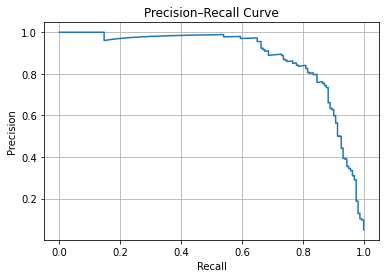

Chosen threshold ≈ 0.180

Classification report (tuned):
               precision    recall  f1-score   support

           0      0.991     0.989     0.990      3131
           1      0.800     0.834     0.817       163

    accuracy                          0.981      3294
   macro avg      0.896     0.912     0.904      3294
weighted avg      0.982     0.981     0.982      3294

Confusion matrix (tuned):
 [[3097   34]
 [  27  136]]


In [16]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

# assumes y_test, y_prob already computed (from your best model)
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
print(f"Test PR-AUC: {ap:.3f}")

# plot PR curve (recall on x is often easier for business)
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()

# sweep thresholds to pick by business rule
def pick_threshold(precision, recall, thresholds, min_precision=0.4, maximize="recall"):
    best_idx, best_val = None, -1
    for i in range(len(thresholds)):   # thresholds has len-1 vs prec/rec
        p, r = precision[i], recall[i]
        if p >= min_precision:
            val = r if maximize=="recall" else (2*p*r/(p+r+1e-9))  # F1
            if val > best_val:
                best_val, best_idx = val, i
    if best_idx is None:
        return 0.5  # fallback
    return thresholds[best_idx]

t_star = pick_threshold(precision, recall, thresholds, min_precision=0.8, maximize="recall")
print(f"Chosen threshold ≈ {t_star:.3f}")

y_pred_tuned = (y_prob >= t_star).astype(int)
print("\nClassification report (tuned):\n", classification_report(y_test, y_pred_tuned, digits=3))
print("Confusion matrix (tuned):\n", confusion_matrix(y_test, y_pred_tuned))

In [17]:
import os, json, time, numpy as np
from pathlib import Path

# --- inputs expected to already exist ---
# best model:   best_model  (fallback to xgb if best_model not defined)
# test probs:   y_prob      (np.array of predicted probs on X_test)
# tuned thr:    t_star      (float)
# feature cols: X_train.columns

art_dir = Path("artifacts")
art_dir.mkdir(parents=True, exist_ok=True)

model_obj = globals().get("best_model", globals().get("xgb"))
assert model_obj is not None, "No trained XGBoost model found (best_model/xgb)."

feature_list = list(X_train.columns)
timestamp = time.strftime("%Y%m%d-%H%M%S")

# File paths
model_path      = art_dir / "best_model.xgb"
threshold_path  = art_dir / "threshold.txt"
features_path   = art_dir / "feature_list.json"
meta_path       = art_dir / f"metadata_{timestamp}.json"

# 1) Save model
model_obj.save_model(str(model_path))

# 2) Save threshold
with open(threshold_path, "w") as f:
    f.write(str(float(t_star)))

# 3) Save feature list
with open(features_path, "w") as f:
    json.dump(feature_list, f, indent=2)

# 4) Optional: save some metadata for reproducibility
meta = {
    "saved_at": timestamp,
    "horizon_days": int(globals().get("HORIZON_DAYS", 5)),
    "recent_window": int(globals().get("RECENT_WINDOW", 7)),
    "long_window": int(globals().get("LONG_WINDOW", 14)),
    "n_train_rows": int(X_train.shape[0]),
    "n_test_rows": int(X_test.shape[0]),
    "pos_rate_train": float(y_train.mean()),
    "pos_rate_test": float(y_test.mean()),
    "threshold": float(t_star),
    "model_best_ntree_limit": int(getattr(model_obj, "best_ntree_limit", 0)),
}
# If you computed metrics, add them:
try:
    from sklearn.metrics import average_precision_score, roc_auc_score
    meta["pr_auc_test"] = float(average_precision_score(y_test, y_prob))
    meta["roc_auc_test"] = float(roc_auc_score(y_test, y_prob))
except Exception:
    pass

with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

print(f"Saved:\n- {model_path}\n- {threshold_path}\n- {features_path}\n- {meta_path}")

Saved:
- artifacts/best_model.xgb
- artifacts/threshold.txt
- artifacts/feature_list.json
- artifacts/metadata_20250817-113253.json


/Users/ziad/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [18]:
import json
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

# Load artifacts
loaded_model = XGBClassifier()
loaded_model.load_model("artifacts/best_model.xgb")

with open("artifacts/threshold.txt") as f:
    loaded_thr = float(f.read().strip())

with open("artifacts/feature_list.json") as f:
    loaded_features = json.load(f)

# Align test features to saved order (and fill any missing columns with 0)
X_test_aligned = X_test.reindex(columns=loaded_features, fill_value=0)

# Predict & apply threshold
probs = loaded_model.predict_proba(X_test_aligned)[:, 1]
preds = (probs >= loaded_thr).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print("Loaded threshold:", loaded_thr)
print("\nClassification report (loaded artifacts):\n",
      classification_report(y_test, preds, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, preds))

Loaded threshold: 0.18046025931835175

Classification report (loaded artifacts):
               precision    recall  f1-score   support

           0      0.991     0.989     0.990      3131
           1      0.800     0.834     0.817       163

    accuracy                          0.981      3294
   macro avg      0.896     0.912     0.904      3294
weighted avg      0.982     0.981     0.982      3294

Confusion matrix:
 [[3097   34]
 [  27  136]]
